In [1]:
# import PyQt5
# %matplotlib qt
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.transforms as mtransforms

import sys
sys.path.append("/Users/prachigarg/Desktop/assgn5/src") 
from cp_hw5 import integrate_poisson, integrate_frankot, load_sources

from skimage.transform import resize

/Users/prachigarg/opt/anaconda3/envs/CV/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

## Entropy minimization

In [2]:
def normalize_tiff(img):
    return img/(2.0**16.0 - 1.0)

In [3]:
def convert_xyz(img):
    M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
     [0.2126729, 0.7151522, 0.0721750],
     [0.0193339, 0.1191920, 0.9503041]])
    xyz = np.matmul(img, M_RGB_XYZ)
    lumi_channel = xyz[:, :, 1]
    return lumi_channel
def crop(img):
    return img[890:1800, 2290:3100]

0.0 0.23596551461051346


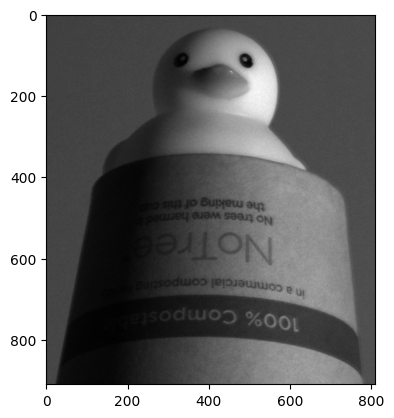

0.0 0.19665827420462348


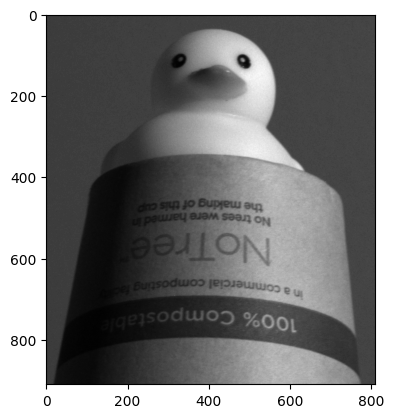

0.0 0.18419165331502252


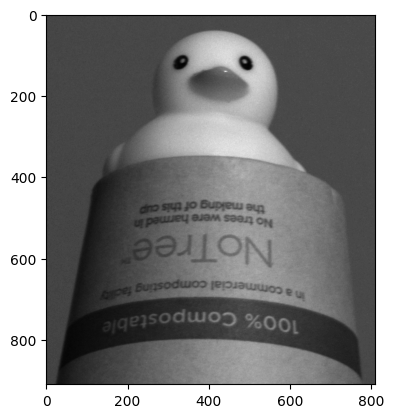

0.0 0.1598535133897917


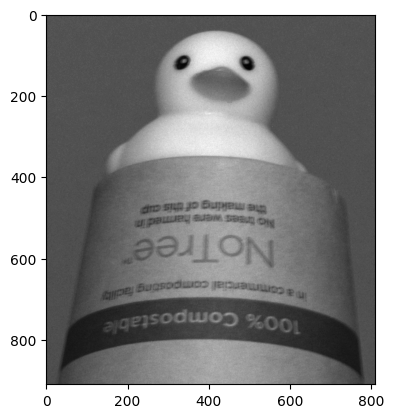

0.0 0.21455710688944837


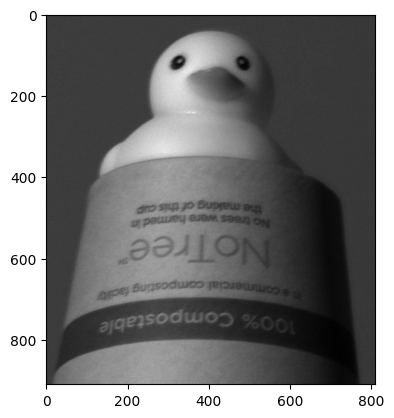

0.0 0.4187838559548333


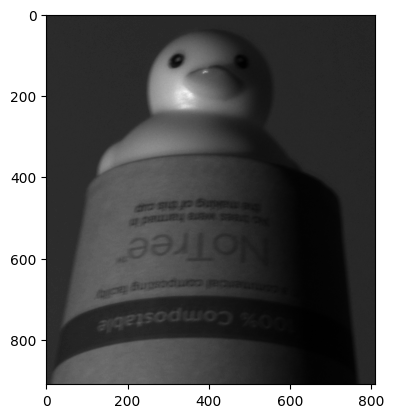

(6, 737100)


In [4]:
I = []
h = 0
w = 0
for id in range(1, 7, 1):
    img = skimage.io.imread('data/photometric_stereo1/DSC_{}.tiff'.format(id))
    img = normalize_tiff(img)
    print(img.min(), img.max())
    luminance = convert_xyz(img)
    luminance = crop(luminance)
    plt.imshow(luminance, cmap='gray')
    plt.show()
    if id == 1:
        h, w = luminance.shape
    I.append(luminance.flatten())
I = np.stack(I, axis=0)

print(I.shape)

In [5]:
h, w

(910, 810)

In [6]:
def map_normal(normal_img):
    return (normal_img + 1.0)/2.0

def decompose_pseudo_normal(B):
    # input shape B: (3, HxW)
    # returns albedo and norm
    print(f'check B {B.shape}')
    A = np.linalg.norm(B, axis=0)
    N = B / A
    print(A.shape, N.shape)

    A = np.reshape(A, (h, w))
    N = np.reshape(N.T, (h, w, 3))
    print(f'reshaped albedo {A.shape}, reshaped normal map {N.shape}')
    
    N_vis = map_normal(N)
    print(N_vis.min(), N_vis.max())
    
    return A, N_vis

def normalize_01(depth):
    return (depth - depth.min()) / (depth.max() - depth.min())

In [7]:
# rank 3 decomposition
U, S, Vh = np.linalg.svd(I, full_matrices=False)
S = np.diag(S)
print(U.shape, S.shape, Vh.shape)
singular_vals = np.sqrt(S)[:3, :3]
print(singular_vals)

Le = np.matmul(U[:, :3], singular_vals)
Be = np.matmul(singular_vals, Vh[:3, :])
print(Le.shape, Be.shape)

(6, 6) (6, 6) (6, 737100)
[[10.24773364  0.          0.        ]
 [ 0.          6.45492222  0.        ]
 [ 0.          0.          3.20685782]]
(6, 3) (3, 737100)


In [8]:
be = np.reshape(np.transpose(Be), (h, w, 3))

# apply blur
sigma = 4.0
be_blur = []
for i in range(3):
    channel_blur = scipy.ndimage.gaussian_filter(be[:, :, i], sigma)
    be_blur.append(channel_blur)
be_blur = np.stack(be_blur, axis=2)
print(be_blur.shape)

# x and y gradients 
dx = np.gradient(be_blur, axis=1)
dy = np.gradient(be_blur, axis=0)
print(dx.shape, dy.shape)

(910, 810, 3)
(910, 810, 3) (910, 810, 3)


In [9]:
be_allpix = np.reshape(be, (-1, 3))
dx_allpix = np.reshape(dx, (-1, 3))
dy_allpix = np.reshape(dy, (-1, 3))
print(be_allpix.shape)
# A
A1 = (be_allpix[:, 0] * dx_allpix[:, 1]) - (be_allpix[:, 1] * dx_allpix[:, 0])
A2 = (be_allpix[:, 0] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 0])
A3 = (be_allpix[:, 1] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 1])
A4 = -(be_allpix[:, 0] * dy_allpix[:, 1]) + (be_allpix[:, 1] * dy_allpix[:, 0])
A5 = -(be_allpix[:, 0] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 0])
A6 = -(be_allpix[:, 1] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 1])

A_mat = np.stack((A1, A2, A3, A4, A5, A6), axis=1)
A_mat.shape

(737100, 3)


(737100, 6)

In [10]:
u, s, vh = np.linalg.svd(A_mat, full_matrices=False)
print(u.shape, vh.shape)
x = vh[-1, :] # null space, last row of vh
print(x)
delta = np.array([[-x[2], x[5], 1], [x[1], -x[4], 0], [-x[0], x[3], 0]])
print(delta)

(737100, 6) (6, 6)
[ 0.16863268 -0.58772927 -0.27340068  0.54824173 -0.02330993  0.50027697]
[[ 0.27340068  0.50027697  1.        ]
 [-0.58772927  0.02330993  0.        ]
 [-0.16863268  0.54824173  0.        ]]


In [11]:
delta_inv = np.linalg.inv(delta)
print(delta_inv.shape, be.shape)
be_integrate = np.matmul(delta_inv, Be)
print(be_integrate.shape)

(3, 3) (910, 810, 3)
(3, 737100)


### modified for entropy minimization

In [12]:
# Apply GBR and return albedo and normals
def apply_GBR(be_integrate, lamda=-1, mu=0, vu=0):
    print(f'lambda {lamda}, mu {mu}, v {vu}')
    G_f = np.array([[1, 0, 0], [0, 1, 0], [mu, vu, lamda]])
    G_temp = np.linalg.inv(G_f)
    be_integrate_ = np.matmul(G_temp, be_integrate)
    A_int, N_int = decompose_pseudo_normal(be_integrate_)
    A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())
    
    return A_int, N_int

In [13]:
lamda_values = np.arange(0, 5, 1)
mu_values = np.arange(-5, 5, 1)
v_values = np.arange(-5, 5, 1)
min_entropy = 10.0
req_lamda = 6.0
req_mu = 6.0
req_vu = 6.0

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lambda 1, mu -5, v -5
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.135115359489184e-06 0.999957201980266
0.0 1.0
4.975413274620921
lambda 1, mu -5, v -4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.0890104512091305e-06 0.9999876357608841
0.0 1.0
4.984537065728448
lambda 1, mu -5, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.043523683578854e-06 0.9999995601688426
0.0 1.0
4.959701956965892
lambda 1, mu -5, v -2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.998644055564938e-06 0.9999998784067934
0.0 1.0
4.857096983577164
lambda 1, mu -5, v -1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.954360809994451e-06 0.9993932592742784
0.0 1.0
4.587838374354561
lambda 1, mu -5, v 0
check B (3, 73

check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.967475547290601e-06 0.9999981505825459
0.0 1.0
4.580345529113813
lambda 1, mu -1, v 0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.9236049269318904e-06 0.9999972338989811
0.0 1.0
4.232952288353157
lambda 1, mu -1, v 1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.167623601558645e-06 0.9999973347840124
0.0 1.0
4.179814032465107
lambda 1, mu -1, v 2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.837589389017349e-06 0.9999971966925443
0.0 1.0
4.177097705250011
lambda 1, mu -1, v 3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.795424431047746e-06 0.9999969947702154
0.0 1.0
4.165249722418742
lambda 1, mu -1, v 4
check B (3, 737100)
(737100,) (3, 73710

4.850242913467806e-06 0.9824074175029147
0.0 1.0
4.835536613431014
lambda 1, mu 3, v 3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.807912776183532e-06 0.9874584289249351
0.0 1.0
4.837090001606842
lambda 1, mu 3, v 4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.76613437749851e-06 0.9910100416951606
0.0 1.0
4.833575419252203
lambda 1, mu 4, v -5
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.166332945172325e-06 0.9999634440616434
0.0 1.0
4.339736872421034
lambda 1, mu 4, v -4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.119807928999354e-06 0.999986864504625
0.0 1.0
4.34974386597573
lambda 1, mu 4, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.073908557751139e-06 0.9999997074940177
0.0 

4.93201481973336
lambda 2, mu -2, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
2.021356695375287e-05 0.9999996345179623
0.0 1.0
4.972156102904597
lambda 2, mu -2, v -2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
2.0033526548723923e-05 0.9999999705548095
0.0 1.0
4.941947013446832
lambda 2, mu -2, v -1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.985588083291967e-05 0.9999900199566326
0.0 1.0
4.6458405714327995
lambda 2, mu -2, v 0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.837845625970676e-06 0.9999910509106876
0.0 1.0
4.444587118022939
lambda 2, mu -2, v 1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.2812980255683115e-06 0.9999876849785516
0.0 1.0
4.298614880577884
lambda 2, mu -2, 

3.944534826216817e-06 0.915388740762391
0.0 1.0
4.810743608258502
lambda 2, mu 2, v 3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.9218313429492095e-05 0.9438356136681467
0.0 1.0
4.810850121697694
lambda 2, mu 2, v 4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.9051376842826873e-05 0.9611775271122797
0.0 1.0
4.80504261622947
lambda 2, mu 3, v -5
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
2.065044162141705e-05 0.9999651517205161
0.0 1.0
4.399932590543176
lambda 2, mu 3, v -4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
2.046454647502971e-05 0.9999941402804642
0.0 1.0
4.430819404836002
lambda 2, mu 3, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
2.0281150167000828e-05 0.9999998455081627


(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.544676188550367e-05 0.99999975161102
0.0 1.0
4.987200525258158
lambda 3, mu -3, v -2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.5042136127104726e-05 0.9999999855602512
0.0 1.0
4.899445454853211
lambda 3, mu -3, v -1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.4642889923285356e-05 0.999973941077142
0.0 1.0
4.692201881708409
lambda 3, mu -3, v 0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.8140267669128924e-06 0.9999812971709048
0.0 1.0
4.524151111193695
lambda 3, mu -3, v 1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.1992434179042277e-06 0.999986293375168
0.0 1.0
4.411603089035698
lambda 3, mu -3, v 2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo 

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.005870914951636e-06 0.9556492978719826
0.0 1.0
4.8228137018264885
lambda 3, mu 1, v 3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.0230129070254446e-05 0.9668114872037334
0.0 1.0
4.821209852725461
lambda 3, mu 1, v 4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
7.3652793242673376e-06 0.9754239719930373
0.0 1.0
4.810855317777813
lambda 3, mu 2, v -5
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.3466184147810125e-06 0.999986173131761
0.0 1.0
4.494030188132893
lambda 3, mu 2, v -4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
7.003102245550785e-06 0.9999961994311444
0.0 1.0
4.542723463623822
lambda 3, mu 2, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (

8.073184605050798e-05 0.9999998598982471
0.0 1.0
4.976422063610637
lambda 4, mu -4, v -2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
8.001338027169291e-05 0.9999999910552566
0.0 1.0
4.877951883439666
lambda 4, mu -4, v -1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
7.930446211790176e-05 0.9999971648249008
0.0 1.0
4.723272477939038
lambda 4, mu -4, v 0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.909387537468721e-06 0.9999965758116405
0.0 1.0
4.5858310079232805
lambda 4, mu -4, v 1
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.323227814598038e-06 0.9999959196759662
0.0 1.0
4.482403491218365
lambda 4, mu -4, v 2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.108953045091958e-07 0.9999951964186

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.9072662398639295e-06 0.9954563955998218
0.0 1.0
4.6512446410749915
lambda 4, mu 0, v 4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.047556009689757e-06 0.9964484938661948
0.0 1.0
4.637985498571668
lambda 4, mu 1, v -5
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
8.825228043907174e-06 0.9999923180262991
0.0 1.0
4.677248327780182
lambda 4, mu 1, v -4
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
7.312435986617238e-06 0.9999970379511485
0.0 1.0
4.692280370235107
lambda 4, mu 1, v -3
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.621302321041522e-06 0.9999999036602591
0.0 1.0
4.709061341557496
lambda 4, mu 1, v -2
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (

In [15]:
min_entropy, req_lamda, req_mu, req_vu

(3.9301272006423145, 1, -3, 4)

In [16]:
lamda_values = np.linspace(req_lamda-1.0, req_lamda+1.0, num=8)
mu_values = np.linspace(req_mu-1.0, req_mu+1.0, num=8)
v_values = np.linspace(req_vu-1.0, req_vu+1.0, num=8)

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lambda 0.2857142857142857, mu -4.0, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.907063825803192e-07 0.9999830191809864
0.0 1.0
4.162461585916073
lambda 0.2857142857142857, mu -4.0, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.897340256631132e-07 0.9999560728694236
0.0 1.0
4.1305080949936475
lambda 0.2857142857142857, mu -4.0, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.887652942347053e-07 0.9999083247208255
0.0 1.0
4.112122785748527
lambda 0.2857142857142857, mu -4.0, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.8780017008743783e-07 0.9998397926129005
0.0 1.0
4.099339534649332
lambda 0.2857142857142857, mu -4.0, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
resha

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.8808696584125e-07 0.9999051030574045
0.0 1.0
3.9985824175494673
lambda 0.2857142857142857, mu -2.857142857142857, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.8712436500887293e-07 0.9998521452413751
0.0 1.0
4.005624225460763
lambda 0.2857142857142857, mu -2.857142857142857, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.861653411485477e-07 0.9998726639029072
0.0 1.0
4.015134637263155
lambda 0.2857142857142857, mu -2.857142857142857, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.852098766077283e-07 0.9998916434865546
0.0 1.0
4.026039736325948
lambda 0.2857142857142857, mu -2.857142857142857, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), 

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5358962568989831e-06 0.9998315831208223
0.0 1.0
4.000772987971519
lambda 0.5714285714285714, mu -3.7142857142857144, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5631099380408742e-06 0.9987364046271976
0.0 1.0
4.105316578919167
lambda 0.5714285714285714, mu -3.7142857142857144, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5592194563818218e-06 0.9992256330800002
0.0 1.0
4.075452669055121
lambda 0.5714285714285714, mu -3.7142857142857144, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5553434813964095e-06 0.999447314050233
0.0 1.0
4.055169614821943
lambda 0.5714285714285714, mu -3.7142857142857144, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5487779905232202e-06 0.9999156788472295
0.0 1.0
3.9926115429043185
lambda 0.5714285714285714, mu -2.5714285714285716, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5449408599099712e-06 0.9999399626438084
0.0 1.0
4.006609886518495
lambda 0.5714285714285714, mu -2.5714285714285716, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.541117971570749e-06 0.9999594986743925
0.0 1.0
4.020535274396093
lambda 0.5714285714285714, mu -2.5714285714285716, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.5373092549508804e-06 0.9999742852686336
0.0 1.0
4.034412315628084
lambda 0.5714285714285714, mu -2.2857142857142856, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshap

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.517629201532646e-06 0.999927063096538
0.0 1.0
4.0740774829687245
lambda 0.8571428571428571, mu -3.428571428571429, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.508873285762437e-06 0.99991646692971
0.0 1.0
4.041335945937902
lambda 0.8571428571428571, mu -3.428571428571429, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.500150021429338e-06 0.9998897131403666
0.0 1.0
4.01157286785874
lambda 0.8571428571428571, mu -3.428571428571429, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.491459246496298e-06 0.9998598436696189
0.0 1.0
3.98370778523872
lambda 0.8571428571428571, mu -3.428571428571429, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.4853737427287257e-06 0.9999876789867501
0.0 1.0
3.992150904520909
lambda 0.8571428571428571, mu -2.2857142857142856, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.476737909013927e-06 0.9999836929927763
0.0 1.0
4.008467830353029
lambda 0.8571428571428571, mu -2.2857142857142856, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.4681341314901637e-06 0.9999773371251395
0.0 1.0
4.023111521164757
lambda 0.8571428571428571, mu -2.2857142857142856, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
3.4595622516175872e-06 0.9999686116549723
0.0 1.0
4.036548748092222
lambda 0.8571428571428571, mu -2.0, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (9

6.254671923389132e-06 0.9996421030595792
0.0 1.0
4.073467267827143
lambda 1.1428571428571428, mu -3.142857142857143, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
4.727301040896581e-06 0.9996265555889405
0.0 1.0
4.044567434977096
lambda 1.1428571428571428, mu -3.142857142857143, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.223589696985332e-06 0.9996106762607695
0.0 1.0
4.014470283726521
lambda 1.1428571428571428, mu -3.142857142857143, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.208135395813219e-06 0.9995944651701716
0.0 1.0
3.9841065585402657
lambda 1.1428571428571428, mu -3.142857142857143, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.192738586707769e-06 0.9995779224

6.197313900280221e-06 0.9999910945712382
0.0 1.0
4.007205950810767
lambda 1.1428571428571428, mu -2.0, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.181957306006236e-06 0.9999928191146128
0.0 1.0
4.01444827537104
lambda 1.1428571428571428, mu -2.0, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.16665771996372e-06 0.9999937997991148
0.0 1.0
4.0246878123452134
lambda 1.1428571428571428, mu -2.0, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.151414860211535e-06 0.9999940366116138
0.0 1.0
4.036694180583367
lambda 1.4285714285714284, mu -4.0, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.767384800241086e-06 0.9999893292298698
0.0 1.0
4.175629905712086
lambda 1.4285714285714284, mu -4.0, v 3.28571428571428

4.07856309202759
lambda 1.4285714285714284, mu -2.857142857142857, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.160175109597542e-06 0.9999905085099543
0.0 1.0
4.0551959232584
lambda 1.4285714285714284, mu -2.857142857142857, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.72605659366188e-06 0.9999915149921528
0.0 1.0
4.032162554386529
lambda 1.4285714285714284, mu -2.857142857142857, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.7019030547707e-06 0.99999245977919
0.0 1.0
4.012966694050137
lambda 1.4285714285714284, mu -2.857142857142857, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.67783937722011e-06 0.9999933428700167
0.0 1.0
3.997049101382183
lambda 1.4285714285714284,

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.3925625247435125e-05 0.9999829461315647
0.0 1.0
4.090416864398419
lambda 1.7142857142857142, mu -4.0, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.3891141379229754e-05 0.999979884900558
0.0 1.0
4.0708870619467765
lambda 1.7142857142857142, mu -4.0, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.3856785438914887e-05 0.9999762455754514
0.0 1.0
4.052299979749281
lambda 1.7142857142857142, mu -4.0, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.3822556794440555e-05 0.9999720281941173
0.0 1.0
4.034302330360484
lambda 1.7142857142857142, mu -3.7142857142857144, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
9.796945314888283

(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.3832728226970126e-05 0.9999967240086955
0.0 1.0
4.011488051549142
lambda 1.7142857142857142, mu -2.5714285714285716, v 3.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
8.528272627816857e-06 0.9999661054523508
0.0 1.0
4.090806180741273
lambda 1.7142857142857142, mu -2.5714285714285716, v 3.2857142857142856
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
5.499140366738153e-06 0.9999709160861321
0.0 1.0
4.08288305923518
lambda 1.7142857142857142, mu -2.5714285714285716, v 3.571428571428571
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.4007934082349571e-05 0.9999751988929373
0.0 1.0
4.0771551604820875
lambda 1.7142857142857142, mu -2.5714285714285716, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910,

1.900465865195544e-05 0.9994565451365638
0.0 1.0
4.1082187505391525
lambda 2.0, mu -3.7142857142857144, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8957535658337132e-05 0.9994925251631079
0.0 1.0
4.088355363525788
lambda 2.0, mu -3.7142857142857144, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8910587710141424e-05 0.9995459700269255
0.0 1.0
4.071125535611594
lambda 2.0, mu -3.7142857142857144, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8863813941338847e-05 0.9995835936973456
0.0 1.0
4.055567529006224
lambda 2.0, mu -3.7142857142857144, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8817213491506557e-05 0.9996053854446526
0.0 1.0
4.041283898341412
lambda 2.0, mu -3.428571428571429,

0.0 1.0
4.129511027121023
lambda 2.0, mu -2.2857142857142856, v 3.857142857142857
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.9022230236753757e-05 0.9999931454914799
0.0 1.0
4.125393814680442
lambda 2.0, mu -2.2857142857142856, v 4.142857142857142
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8975041915503255e-05 0.9999921378016119
0.0 1.0
4.121196885512113
lambda 2.0, mu -2.2857142857142856, v 4.428571428571429
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.8928028962916787e-05 0.9999909394379105
0.0 1.0
4.116610940411541
lambda 2.0, mu -2.2857142857142856, v 4.714285714285714
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
1.888119051129955e-05 0.9999895504044886
0.0 1.0
4.111408812111169
lambda 2.0, mu -2.2857142857142856, v 5.0
check B (3, 737100)
(

In [18]:
min_entropy, req_lamda, req_mu, req_vu

(3.9103156779164783, 1.1428571428571428, -3.142857142857143, 5.0)

In [19]:
A_int, N_int = apply_GBR(be_integrate, req_lamda, req_mu, req_vu)

lambda 1.1428571428571428, mu -3.142857142857143, v 5.0
check B (3, 737100)
(737100,) (3, 737100)
reshaped albedo (910, 810), reshaped normal map (910, 810, 3)
6.14689027189641e-06 0.9996369734965589


In [82]:
# def render_lighting(Light):
#     be_lighting = np.dot(Light, Be)
#     I = np.reshape(be_lighting, (h, w))
#     return I

In [83]:
# L1 = np.array([[-0.95, 0.0, 0.0]])
# L2 = np.array([[0.1, 0.0, 0.0]])

# I1 = render_lighting(L1)
# I2 = render_lighting(L2)

# %matplotlib inline 
# plot_2fig(I1, I2, 'lighting_img2.png', 'Light source 1', 'Light source 2')

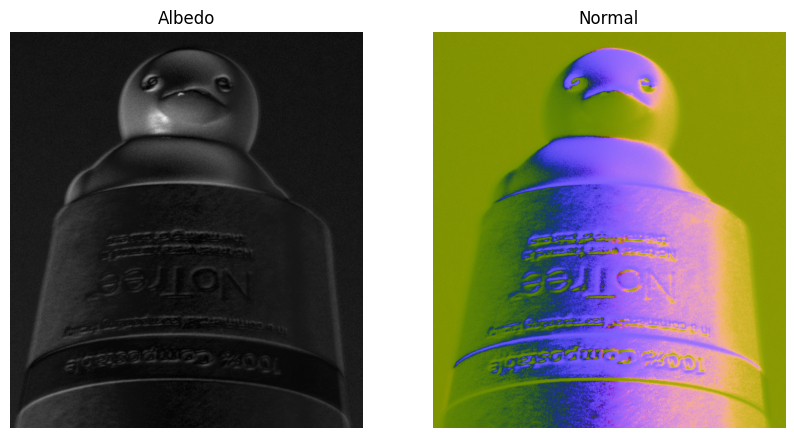

In [23]:
%matplotlib inline 
plot_2fig(A_int, N_int, 'img1_entropy_min.png', 'Albedo', 'Normal')

In [48]:
eps = 1e-2
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

# Z = integrate_frankot(zx, zy)
Z = integrate_poisson(zx, zy)
Z.min(), Z.max()

(-19304.84989972218, 8610.365659641324)

0.0 1.0


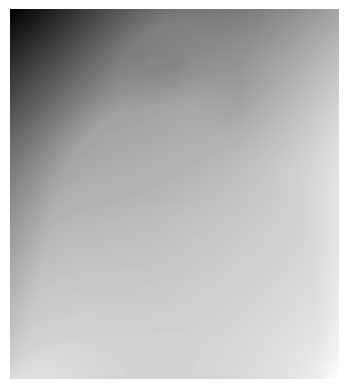

In [49]:
%matplotlib inline 
Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_img1_entropy_min.png')

In [47]:
import PyQt5
%matplotlib qt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
# x, y = np.meshgrid(np.arange(0,W,5), np.arange(0,H,5))
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
print(Z.shape, x.shape, y.shape)
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
ls = LightSource()

Z_temp = Z[0::5, 0::5]
print(Z_temp.shape)

color_shade = ls.shade(Z, plt.cm.gray)
# (control surface resolution using rstride and cstride)
ax.view_init(elev=90, azim=105)
surf = ax.plot_surface(x, y, Z, facecolors=color_shade, rstride=4, cstride=4)

# turn off axis
plt.axis('off')
plt.tight_layout()
# plt.savefig('imcddee_30.png', dpi=1200)
plt.show()

(910, 810) (910, 810) (910, 810)
(182, 162)


2023-11-23 18:34:36.650 python[10744:522904] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (2.16 secs).
2023-11-23 18:34:36.650 python[10744:522904] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (2.16 secs).
2023-11-23 18:34:39.338 python[10744:522904] +[CATransaction synchronize] called within transaction
2023-11-23 18:34:39.822 python[10744:522904] +[CATransaction synchronize] called within transaction
2023-11-23 18:34:45.396 python[10744:522904] +[CATransaction synchronize] called within transaction
2023-11-23 18:34:50.780 python[10744:522904] +[CATransaction synchronize] called within transaction
2023-11-23 18:34:51.054 python[10744:522904] +[CATransaction synchronize] called within transaction
20